**The idea was to cluster Moroccan Cities, but since there isn't enough data about most cities, I switched the project into classifying neighborhoods in Casablanca.** <br>
**The idea is the same, " Which neighborhood(s) is similar to the one I actually live in, in terms of the venues existing ? ".**

# I. Importing Libraries

In [1]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup
import lxml.etree as xml
import re
import json
import folium
from geopy.geocoders import Nominatim

pd.set_option('mode.chained_assignment', None)

# II. Data Stuff

## Get Casablanca's Neighborhoods Coordinates

In [54]:
# Lissasfa, Attacharok, California
boroughs = ["Ain Diab", "EL Hank", "Bourgogne", "Anfa", "Hay Hassani", "Roches Noires", "El Maarif", "Hay Mohammadi", "Ain Sebâa", "Sbata", "LES HOPITAUX",
            "Bachkou", "La villette", "Ain Borja", "Belvédère", "La Gironde", "El Oulfa", "Liberte", "Sidi Belyout", "Ennassim", "Beauséjour",
           "Sidi Bernoussi", "Sidi Moumen", "Moulay Rachid", "Sidi Othmane", "Al Fida", "Ben M'Sick", "Mers Sultan", "Ain Chock", "Sidi Maarouf"]
list_boroughs = []
for borough in boroughs:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(str(borough)+" Casablanca, MA")
        latitude = location.latitude
        longitude = location.longitude
    #     print('The geograpical coordinate of ',adr,' are {}, {}.'.format(latitude, longitude))
        list_boroughs.append(["Casablanca", borough, latitude, longitude])
        
    except Exception as e:
        print(str(borough),":",e)
    
dataframe = pd.DataFrame(list_boroughs, columns = ['City', 'Borough', 
                  'Latitude', 
                  'Longitude'])

# Correcting Roches Noires
dataframe['Latitude'][5] = 33.6019857570432
dataframe['Longitude'][5] = -7.5761202770865665

# Correcting Habous
dataframe['Latitude'][10] = 33.580401
dataframe['Longitude'][10] = -7.6168444

# Correcting Anfa
dataframe['Latitude'][3] = 33.58253365003965
dataframe['Longitude'][3] = -7.661577829113101

# Correcting Bachkou
dataframe['Latitude'][11] = 33.5563046
dataframe['Longitude'][11] = -7.6322097

dataframe

,City,Borough,Latitude,Longitude
0,Casablanca,Ain Diab,33.592288,-7.676419
1,Casablanca,EL Hank,33.602816,-7.654126
2,Casablanca,Bourgogne,33.597893,-7.638162
3,Casablanca,Anfa,33.582534,-7.661578
4,Casablanca,Hay Hassani,33.567046,-7.678489
5,Casablanca,Roches Noires,33.601986,-7.576120
6,Casablanca,El Maarif,33.576130,-7.636660
7,Casablanca,Hay Mohammadi,33.584144,-7.556956
8,Casablanca,Ain Sebâa,33.605994,-7.538794
9,Casablanca,Sbata,33.537659,-7.564046


## Visualize Neighborhoods in Casablanca

In [86]:
geolocator = Nominatim(user_agent="ny_explorer")
location_casa = geolocator.geocode("Casablanca, MA")
latitude_casa = location_casa.latitude
longitude_casa = location_casa.longitude
    
# create map of New York using latitude and longitude values
f = folium.Figure(width=1000, height=500)
casa = folium.Map(location=[latitude_casa, longitude_casa], zoom_start=12).add_to(f)

# add boroughs to map
for lat, lng, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.5,
        parse_html=False).add_to(casa)
casa

## Get Venues of Each Borough

### Initialize Foursquare Stuff

In [56]:
CLIENT_ID = 'K11QLHP35WUZC4RTZHMVWMLCFLGP4ILK1H4NPHEZB4OIEWLF' # your Foursquare ID
CLIENT_SECRET = 'JFAR1EPYRUPE55NSEXLC5LVQB4RCBYPOIH43SXWL51ZA5H1F' # your Foursquare Secret

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: K11QLHP35WUZC4RTZHMVWMLCFLGP4ILK1H4NPHEZB4OIEWLF
CLIENT_SECRET:JFAR1EPYRUPE55NSEXLC5LVQB4RCBYPOIH43SXWL51ZA5H1F


## Get Results and Store in Json Files

**Send Request for each Neighborhood and store the results in seperate files.**

In [57]:
# RUN ONLY IF CHANGES ARE REQUIRED

radius = 2000 # Radius in meters
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

for borough in dataframe.values.tolist():

    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION,
        borough[2], 
        borough[3], 
        radius, 
        LIMIT)
    try:
        with open("Casablanca_Data/"+str(borough[1])+'.json', 'w') as outfile:
            json.dump(requests.get(url).json(), outfile)
    except Exception as e:
        print("Error in",borough[1])

## Read Json Files and store in Dataframe

**Read the results and store in Dataframe**

In [59]:
boroughs_venues_list = []

for borough in dataframe["Borough"].values.tolist():
#     print(borough)
    with open("Casablanca_Data/"+str(borough)+'.json') as json_file:
        try:
            results = json.load(json_file)
            res = results["response"]["groups"][0]["items"]
            venues_list = []

            for v in res:

                venues_list.append([
                        borough,
                        v['venue']['name'],
                        v['venue']['location']['lat'], 
                        v['venue']['location']['lng'],  
                        v['venue']['categories'][0]['name']])
                boroughs_venues_list.append(venues_list)
            
        except Exception as e:
            print(e)

print("Exemple of Venue :", boroughs_venues_list[0][0])

Exemple of Venue : ['Ain Diab', 'Basmane Restaurant', 33.59157681057596, -7.677553140193589, 'Moroccan Restaurant']


In [61]:
nearby_venues = pd.DataFrame([item for a in boroughs_venues_list for item in a])
nearby_venues.columns = ['Borough',
                         'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

nearby_venues

,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ain Diab,Basmane Restaurant,33.591577,-7.677553,Moroccan Restaurant
1,Ain Diab,Sinatra,33.595661,-7.677022,Italian Restaurant
2,Ain Diab,Le Boudoir,33.593305,-7.677625,Lounge
3,Ain Diab,Sun Beach - CCC,33.595406,-7.678437,Pool
4,Ain Diab,Mercat,33.596119,-7.678204,Tapas Restaurant
...,...,...,...,...,...
100162,Sidi Maarouf,Theodor,33.522057,-7.648748,Café
100163,Sidi Maarouf,Patisserie Mon Ami,33.542737,-7.665278,Bakery
100164,Sidi Maarouf,NewPrise Café,33.525314,-7.659474,Coffee Shop
100165,Sidi Maarouf,FC Casablanca,33.530127,-7.664166,Soccer Stadium


**Merge the original Dataframe with the one containing Foursquare's Data.<br>
Delete any duplicated rows.**

In [62]:
boroughs_merged = dataframe.join(nearby_venues.set_index('Borough'), on='Borough')
boroughs_merged.to_csv("Cities_API/cities_venues.csv")
boroughs_merged.drop_duplicates(inplace=True)
boroughs_merged.drop(columns=["Latitude", "Longitude"], inplace=True)
boroughs_merged

,City,Borough,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Casablanca,Ain Diab,Basmane Restaurant,33.591577,-7.677553,Moroccan Restaurant
0,Casablanca,Ain Diab,Sinatra,33.595661,-7.677022,Italian Restaurant
0,Casablanca,Ain Diab,Le Boudoir,33.593305,-7.677625,Lounge
0,Casablanca,Ain Diab,Sun Beach - CCC,33.595406,-7.678437,Pool
0,Casablanca,Ain Diab,Mercat,33.596119,-7.678204,Tapas Restaurant
...,...,...,...,...,...,...
29,Casablanca,Sidi Maarouf,Theodor,33.522057,-7.648748,Café
29,Casablanca,Sidi Maarouf,Patisserie Mon Ami,33.542737,-7.665278,Bakery
29,Casablanca,Sidi Maarouf,NewPrise Café,33.525314,-7.659474,Coffee Shop
29,Casablanca,Sidi Maarouf,FC Casablanca,33.530127,-7.664166,Soccer Stadium


**Calculate the total number of Venues for each Neighborhood.**

In [63]:
ratio = pd.DataFrame(boroughs_merged["Borough"].value_counts())
ratio.rename(columns={"Borough": "Total"}, inplace=True)
ratio['Borough'] = ratio.index
ratio.reset_index(inplace=True)
ratio.drop(columns=["index"], inplace=True)
ratio

,Total,Borough
0,100,Liberte
1,100,Bourgogne
2,100,Anfa
3,100,Sidi Belyout
4,100,El Maarif
5,100,LES HOPITAUX
6,100,La Gironde
7,80,EL Hank
8,75,Ain Diab
9,70,Mers Sultan


## Visualize Venue & Neighborhoods in Casablanca

In [130]:
import seaborn as sns
palette = sns.color_palette(None, len(dataframe["Borough"]))

In [172]:
with open("casa_data.json") as json_file:
    borough_geo = json.load(json_file)
    
# create map of New York using latitude and longitude values
f = folium.Figure(width=1000, height=500)
casa = folium.Map(location=[latitude_casa, longitude_casa], zoom_start=12, tiles='Stamen Terrain').add_to(f)

# casa.choropleth(
#  geo_data=borough_geo,
#  name='choropleth',
#  data=ratio,
#  columns=['Borough', 'Total'],
#  key_on='feature.properties.name',
#  fill_color='YlOrRd', # ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
#  fill_opacity=0.5,
#  line_opacity=0.7,
#  legend_name='Total N° of Venues'
# )
# folium.LayerControl().add_to(casa)

# add boroughs to map
for lat, lng, borough in zip(dataframe['Latitude'], dataframe['Longitude'], dataframe['Borough']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='red',
        fill=True,
        fill_color='white',
        fill_opacity=0.5,
        parse_html=False).add_to(casa)

# add venues to map
for lat, lng, venue, borough in zip(boroughs_merged['Venue Latitude'], boroughs_merged['Venue Longitude'], boroughs_merged['Venue'], boroughs_merged['Borough']):
    try:
        label = folium.Popup(venue, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,
            color='purple',
            fill=True,
            fill_color='purple',
            fill_opacity=0.5,
            parse_html=False).add_to(casa)
    except Exception as e:
        continue

casa

**Number of Venues in each Neighborhood** <br>
Well known Neighborhoods always have the biggest amount of Data.

Text(0.5, 1.0, 'Total Number of Venues of each Borough')

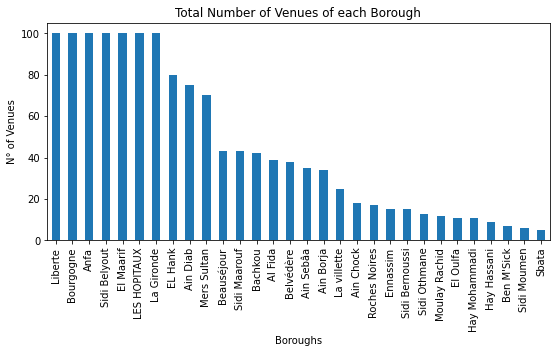

In [65]:
import matplotlib.pyplot as plt

boroughs_plot = boroughs_merged["Borough"].value_counts()
boroughs_plot.plot(kind="bar", figsize=(9,4))
plt.xlabel("Boroughs")
plt.xticks(rotation = 90)
plt.ylabel("N° of Venues")
plt.title("Total Number of Venues of each Borough")

## Convert Categorical Values to Numerical

In [154]:
boroughs_onehot = pd.get_dummies(boroughs_merged[['Venue Category']], prefix="", prefix_sep="")

boroughs_onehot["Borough"] = boroughs_merged["Borough"]
neigh = boroughs_onehot.pop('Borough')
boroughs_onehot.insert(0, 'Borough', neigh)

boroughs_onehot.dropna(inplace=True)
boroughs_onehot

,Borough,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Ain Diab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ain Diab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ain Diab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ain Diab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Ain Diab,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,Sidi Maarouf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Sidi Maarouf,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
29,Sidi Maarouf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Sidi Maarouf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [155]:
unwanted_venues = []
# unwanted_venues = ["Nightclub" ,"Jazz Club", "Train Station", "Yoga Studio", "Wings Joint"]

for (key, value) in boroughs_merged["Venue Category"].value_counts().to_dict().items():
    if value < 0:
        unwanted_venues.append(str(key))
        
boroughs_onehot.drop(columns=unwanted_venues, axis=1, inplace=True)

In [156]:
boroughs_grouped = boroughs_onehot.groupby('Borough').mean().reset_index()
boroughs_grouped.dropna(inplace=True)
boroughs_grouped

,Borough,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,...,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Ain Borja,0.00,0.000000,0.029412,0.00,0.00000,0.000000,0.000000,0.000000,0.029412,...,0.00,0.029412,0.000000,0.000000,0.147059,0.0000,0.00,0.0000,0.000000,0.000000
1,Ain Chock,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.055556,0.000000,0.111111,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
2,Ain Diab,0.00,0.013333,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.026667,...,0.00,0.000000,0.013333,0.000000,0.013333,0.0000,0.00,0.0000,0.000000,0.013333
3,Ain Sebâa,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.057143,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
4,Al Fida,0.00,0.000000,0.025641,0.00,0.00000,0.025641,0.025641,0.025641,0.051282,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
5,Anfa,0.00,0.010000,0.000000,0.00,0.00000,0.010000,0.000000,0.000000,0.040000,...,0.01,0.000000,0.000000,0.000000,0.000000,0.0100,0.00,0.0000,0.000000,0.010000
6,Bachkou,0.00,0.000000,0.000000,0.00,0.02381,0.000000,0.000000,0.000000,0.047619,...,0.00,0.000000,0.000000,0.047619,0.071429,0.0000,0.00,0.0000,0.000000,0.000000
7,Beauséjour,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,0.046512,...,0.00,0.000000,0.000000,0.023256,0.046512,0.0000,0.00,0.0000,0.000000,0.000000
8,Belvédère,0.00,0.000000,0.026316,0.00,0.00000,0.000000,0.000000,0.000000,0.052632,...,0.00,0.026316,0.000000,0.000000,0.052632,0.0000,0.00,0.0000,0.000000,0.000000
9,Ben M'Sick,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.142857,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000


In [157]:
boroughs_grouped = boroughs_grouped.join(ratio.set_index('Borough'), on='Borough')
neigh = boroughs_grouped.pop('Total')
boroughs_grouped.insert(1, 'Total', neigh)
boroughs_grouped

,Borough,Total,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,...,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Ain Borja,34,0.00,0.000000,0.029412,0.00,0.00000,0.000000,0.000000,0.000000,...,0.00,0.029412,0.000000,0.000000,0.147059,0.0000,0.00,0.0000,0.000000,0.000000
1,Ain Chock,18,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.055556,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
2,Ain Diab,75,0.00,0.013333,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.013333,0.000000,0.013333,0.0000,0.00,0.0000,0.000000,0.013333
3,Ain Sebâa,35,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
4,Al Fida,39,0.00,0.000000,0.025641,0.00,0.00000,0.025641,0.025641,0.025641,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
5,Anfa,100,0.00,0.010000,0.000000,0.00,0.00000,0.010000,0.000000,0.000000,...,0.01,0.000000,0.000000,0.000000,0.000000,0.0100,0.00,0.0000,0.000000,0.010000
6,Bachkou,42,0.00,0.000000,0.000000,0.00,0.02381,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.047619,0.071429,0.0000,0.00,0.0000,0.000000,0.000000
7,Beauséjour,43,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.023256,0.046512,0.0000,0.00,0.0000,0.000000,0.000000
8,Belvédère,38,0.00,0.000000,0.026316,0.00,0.00000,0.000000,0.000000,0.000000,...,0.00,0.026316,0.000000,0.000000,0.052632,0.0000,0.00,0.0000,0.000000,0.000000
9,Ben M'Sick,7,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.142857,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000


### Scale "Total" Column between 0 and 1

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [158]:
scaler = MinMaxScaler()

boroughs_grouped["Total_scaled"] = scaler.fit_transform(boroughs_grouped["Total"].values.reshape(-1,1))
neigh = boroughs_grouped.pop('Total_scaled')
boroughs_grouped.insert(1, 'Total_scaled', neigh)
boroughs_grouped

,Borough,Total_scaled,Total,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Arts & Entertainment,Asian Restaurant,Athletics & Sports,...,Thai Restaurant,Theater,Theme Park,Train Station,Tram Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Yoga Studio
0,Ain Borja,0.305263,34,0.00,0.000000,0.029412,0.00,0.00000,0.000000,0.000000,...,0.00,0.029412,0.000000,0.000000,0.147059,0.0000,0.00,0.0000,0.000000,0.000000
1,Ain Chock,0.136842,18,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.055556,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
2,Ain Diab,0.736842,75,0.00,0.013333,0.000000,0.00,0.00000,0.000000,0.000000,...,0.00,0.000000,0.013333,0.000000,0.013333,0.0000,0.00,0.0000,0.000000,0.013333
3,Ain Sebâa,0.315789,35,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
4,Al Fida,0.357895,39,0.00,0.000000,0.025641,0.00,0.00000,0.025641,0.025641,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000
5,Anfa,1.000000,100,0.00,0.010000,0.000000,0.00,0.00000,0.010000,0.000000,...,0.01,0.000000,0.000000,0.000000,0.000000,0.0100,0.00,0.0000,0.000000,0.010000
6,Bachkou,0.389474,42,0.00,0.000000,0.000000,0.00,0.02381,0.000000,0.000000,...,0.00,0.000000,0.000000,0.047619,0.071429,0.0000,0.00,0.0000,0.000000,0.000000
7,Beauséjour,0.400000,43,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.023256,0.046512,0.0000,0.00,0.0000,0.000000,0.000000
8,Belvédère,0.347368,38,0.00,0.000000,0.026316,0.00,0.00000,0.000000,0.000000,...,0.00,0.026316,0.000000,0.000000,0.052632,0.0000,0.00,0.0000,0.000000,0.000000
9,Ben M'Sick,0.021053,7,0.00,0.000000,0.000000,0.00,0.00000,0.000000,0.142857,...,0.00,0.000000,0.000000,0.000000,0.000000,0.0000,0.00,0.0000,0.000000,0.000000


In [159]:
boroughs_grouped.to_csv("boroughs_grouped.csv")

# Clustering

In [23]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
import pickle

## Initialize KMeans

In [160]:
K = range(1,10)
distortions = []
preds = []
models = []

if 'boroughs_grouped' in locals():
    data = boroughs_grouped.drop(columns=["Borough", "Total_scaled"])
else: 
    data = pd.read_csv("boroughs_grouped.csv").drop(columns=["Unnamed: 0", "Borough", "Total_scaled"])
        
for k in K:
#     print("Tryin",k,"Clusters...")
    model = KMeans(n_clusters=k, random_state=0).fit(data)
    models.append(model)
    distortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)) / data.shape[0])
    preds.append(model.labels_)

## Evaluate with Elbow Method

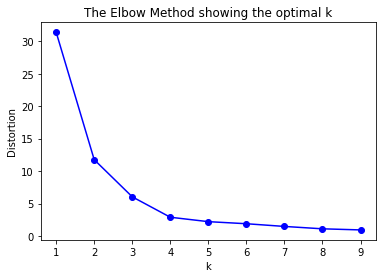

In [161]:
plt.plot(K, distortions, 'bo-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## Evaluate with Silhouette Score

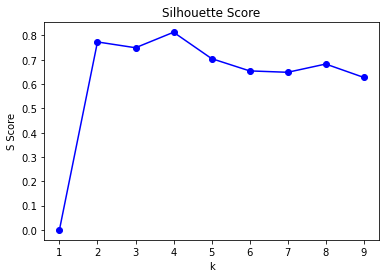

In [162]:
s_score = []

for k, pred in zip(K[1:], preds[1:]):
    s_score.append( metrics.silhouette_score(data, pred, metric='euclidean') )

s_score.insert(0, 0)
    
plt.plot(K, s_score, 'bo-')
plt.xlabel('k')
plt.ylabel('S Score')
plt.title('Silhouette Score')
plt.show()

## Save the Best Model

**K=2 => models[1]**

In [163]:
choice = int(input("Choose manually or according to Silhouette Score : ? \n (S-Score : 1 // Manually : 0) :"))

if choice == 0:
    optimal_K = int(input("Enter Number of Optimal K : "))
    print("Optimal K =",optimal_K)
    pickle.dump(models[optimal_K-1], open("KMeans_model_casablanca_good_1.pkl", "wb"))
    
elif choice == 1:
    optimal_K = s_score.index( max(s_score) )
    print("Optimal K =",optimal_K+1)
    pickle.dump(models[optimal_K], open("KMeans_model_casablanca_good_1.pkl", "wb"))
    
else : print("Dude...")

# print("K =",int(optimal_K),"is the optimal value of K")
# print("Index of model in List : ",optimal_K-1)
# pickle.dump(models[optimal_K], open("KMeans_model_casablanca_good_1.pkl", "wb"))

Choose manually or according to Silhouette Score : ? 
 (S-Score : 1 // Manually : 0) : 1


Optimal K = 4


In [164]:
# Load
model = pickle.load(open("KMeans_model_casablanca_good_1.pkl", "rb"))
print("Loaded & Saved !")

Loaded & Saved !


## Merge Results with Original Dataframe

In [165]:
casablanca_clustered = dataframe

if 'Cluster Labels' in casablanca_clustered:
    casablanca_clustered["Cluster Labels"] = model.labels_
else : casablanca_clustered.insert(2, "Cluster Labels", model.labels_)
    
# casablanca_clustered.drop(columns=["City"], inplace=True)
casablanca_clustered.to_csv("casablanca_clutered_good_1.csv")
casablanca_clustered

,City,Borough,Cluster Labels,Latitude,Longitude
0,Casablanca,Ain Diab,2,33.592288,-7.676419
1,Casablanca,EL Hank,1,33.602816,-7.654126
2,Casablanca,Bourgogne,3,33.597893,-7.638162
3,Casablanca,Anfa,2,33.582534,-7.661578
4,Casablanca,Hay Hassani,2,33.567046,-7.678489
5,Casablanca,Roches Noires,0,33.601986,-7.576120
6,Casablanca,El Maarif,2,33.576130,-7.636660
7,Casablanca,Hay Mohammadi,2,33.584144,-7.556956
8,Casablanca,Ain Sebâa,2,33.605994,-7.538794
9,Casablanca,Sbata,1,33.537659,-7.564046


## Visualize a Clustered Casablanca

In [166]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
f = folium.Figure(width=1000, height=500)
casa_clustered = folium.Map(location=[latitude_casa, longitude_casa], zoom_start=12, tiles='Stamen Terrain').add_to(f)

# set color scheme for the clusters
K = casablanca_clustered["Cluster Labels"].max()+1
x = np.arange(K)
ys = [i + x + (i*x)**2 for i in range(K)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

rainbow = ["#1ac0ff", "#00cd60", "#e74645", "#123456"]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(casablanca_clustered['Latitude'], casablanca_clustered['Longitude'], casablanca_clustered['Borough'], casablanca_clustered['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(casa_clustered)
       
casa_clustered

In [151]:
clustered_bor = []
i = 1

for k in range(0, max(model.labels_)+1):
    cluster = casablanca_clustered.loc[casablanca_clustered['Cluster Labels'] == k]
#     clustered_cities.append(cluster["City"].values.tolist())
    print("CLUSTER",i,":",cluster["Borough"].values.tolist(),"\n")
    i+=1

CLUSTER 1 : ['Roches Noires', 'LES HOPITAUX', 'La villette', 'Liberte', 'Sidi Belyout', 'Beauséjour', 'Al Fida'] 

CLUSTER 2 : ['EL Hank', 'Sbata', 'Ain Borja', 'Belvédère', 'La Gironde', 'El Oulfa', 'Ennassim', 'Sidi Moumen', 'Moulay Rachid', 'Sidi Othmane', "Ben M'Sick", 'Ain Chock', 'Sidi Maarouf'] 

CLUSTER 3 : ['Ain Diab', 'Anfa', 'Hay Hassani', 'El Maarif', 'Hay Mohammadi', 'Ain Sebâa', 'Mers Sultan'] 

CLUSTER 4 : ['Bourgogne', 'Bachkou', 'Sidi Bernoussi'] 



# Conclusion
**As someone who live in Casablanca, The clustering was successfull. Although some neighborhoods should have been assigned to others clusters, but again, there is no enough data on all neighborhoods to make it accurate.**